In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_ta as ta

import pandas_datareader as pdr

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Correlation between rate hikes and crypto prices

1. Get the fed interest rate data for period P
2. Get the crypto price data (proxy as BTC price or total market cap) for period P
3. Check correlation coefficients for data

# Interest rate data

In [29]:
rate_data = os.path.join("..", "data", "FRB_H15.csv")

In [30]:
df_rates = pd.read_csv(rate_data, skiprows=5)
df_rates['Time Period']= pd.to_datetime(df_rates['Time Period'])
df_rates.set_index("Time Period", inplace=True)

In [31]:
df_rates.replace("ND", np.NaN, inplace=True)
df_rates = df_rates.astype("float32")

In [5]:
df_rates = df_rates.loc["2017":"2018"]

In [32]:
df_rates["RIFLGFCY10_N.B"].loc[df_rates["RIFLGFCY10_N.B"] == "ND"] = np.NaN
df_rates["RIFLGFCY10_N.B"] = df_rates["RIFLGFCY10_N.B"].astype("float32")

In [33]:
df_rates["RIFLGFCY02_N.B"].loc[df_rates["RIFLGFCY02_N.B"] == "ND"] = np.NaN
df_rates["RIFLGFCY02_N.B"] = df_rates["RIFLGFCY02_N.B"].astype("float32")

# Get BTC-USD price

In [38]:
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2022-04-30", "%Y-%m-%d")

In [39]:
btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start_date, end=end_date)

# Plot result

In [10]:
btc_data = btc_data.loc["2017":"2018"]

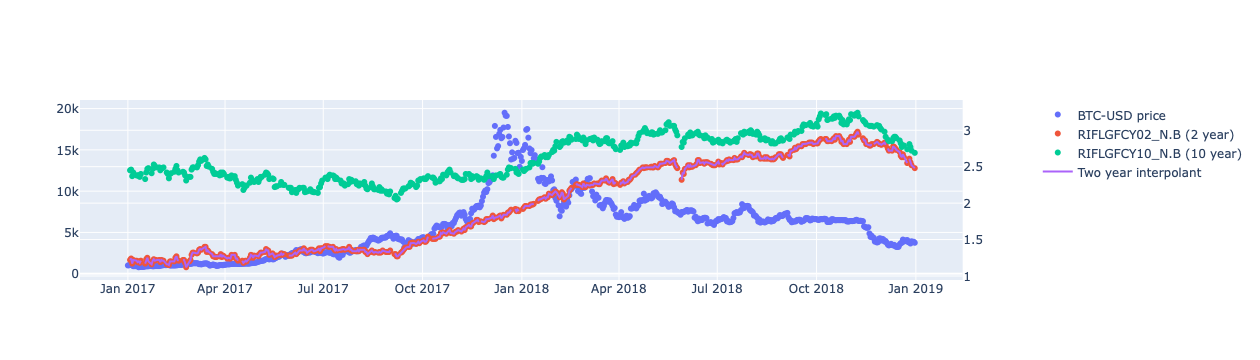

In [12]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_scatter(
    x=btc_data.index,
    y=btc_data["Adj Close"]["BTC-USD"],
    mode="markers",
    name="BTC-USD price",
    secondary_y=False,
)

fig.add_scatter(
    x=df_rates.index,
    y=df_rates["RIFLGFCY02_N.B"],
    mode="markers",
    name="RIFLGFCY02_N.B (2 year)",
    secondary_y=True,
)

fig.add_scatter(
    x=df_rates.index,
    y=df_rates["RIFLGFCY10_N.B"],
    mode="markers",
    name="RIFLGFCY10_N.B (10 year)",
    secondary_y=True,
)

rate_2y = np.interp(btc_data.index, df_rates.index, df_rates["RIFLGFCY02_N.B"])

fig.add_scatter(
    x=btc_data.index,
    y=rate_2y,
    mode="lines",
    name="Two year interpolant",
    secondary_y=True,
)

In [15]:
fig = go.Figure()

fig.add_scatter(
    x=df_rates["RIFLGFCY02_N.B"],
    y=btc_data["Adj Close"]["BTC-USD"],
    mode="markers+lines",
    name="BTC-USD price vs 2Y rate",
)

crossover = 350
fig.add_vrect(
    x0=df_rates["RIFLGFCY02_N.B"].min(),
    x1=df_rates["RIFLGFCY02_N.B"][crossover],
    annotation_text="corr = 0.92", 
    annotation_position="top",
    fillcolor="green", 
    opacity=0.2, 
    line_width=0
)

fig.add_vrect(
    x0=df_rates["RIFLGFCY02_N.B"][crossover],
    x1=df_rates["RIFLGFCY02_N.B"].max(),
    annotation_text="corr = -0.75", 
    annotation_position="top",
    fillcolor="red", 
    opacity=0.2, 
    line_width=0
)

fig.update_xaxes(title_text="2Y Rate (%)")
fig.update_yaxes(title_text="BTC-USD")

fig.update_layout(
    title_text="Price-2RIFLGFCY02_N.B (2 year) correlations during 2017 bull run",
    template="plotly_white"
)

fig.write_image(os.path.join("..", "images", "crypto_interest_rate_correlation.png"))

## Correlation matrix

In [16]:
df_corr = pd.DataFrame(columns=["Date", "Price", "TwoYearRate"])

In [17]:
df_corr.Date = btc_data.index
df_corr = df_corr.set_index("Date")

df_corr.Price = btc_data["Adj Close"]["BTC-USD"]
df_corr.TwoYearRate = rate_2y

In [18]:
df_corr[:"2017"].corr()

,Price,TwoYearRate
Price,1.000000,0.911212
TwoYearRate,0.911212,1.000000


In [19]:
df_corr["2018":].corr()

,Price,TwoYearRate
Price,1.000000,-0.753208
TwoYearRate,-0.753208,1.000000


In [20]:
df_corr["2017":"2018"].corr()

,Price,TwoYearRate
Price,1.000000,0.493728
TwoYearRate,0.493728,1.000000


# Overall comparison

In [34]:
df_rates = df_rates.loc["2017":]

In [35]:
df_rates["RIFLGFCY10_N.B"].loc[df_rates["RIFLGFCY10_N.B"] == "ND"] = np.NaN
df_rates["RIFLGFCY10_N.B"] = df_rates["RIFLGFCY10_N.B"].astype("float32")

In [36]:
df_rates["RIFLGFCY02_N.B"].loc[df_rates["RIFLGFCY02_N.B"] == "ND"] = np.NaN
df_rates["RIFLGFCY02_N.B"] = df_rates["RIFLGFCY02_N.B"].astype("float32")

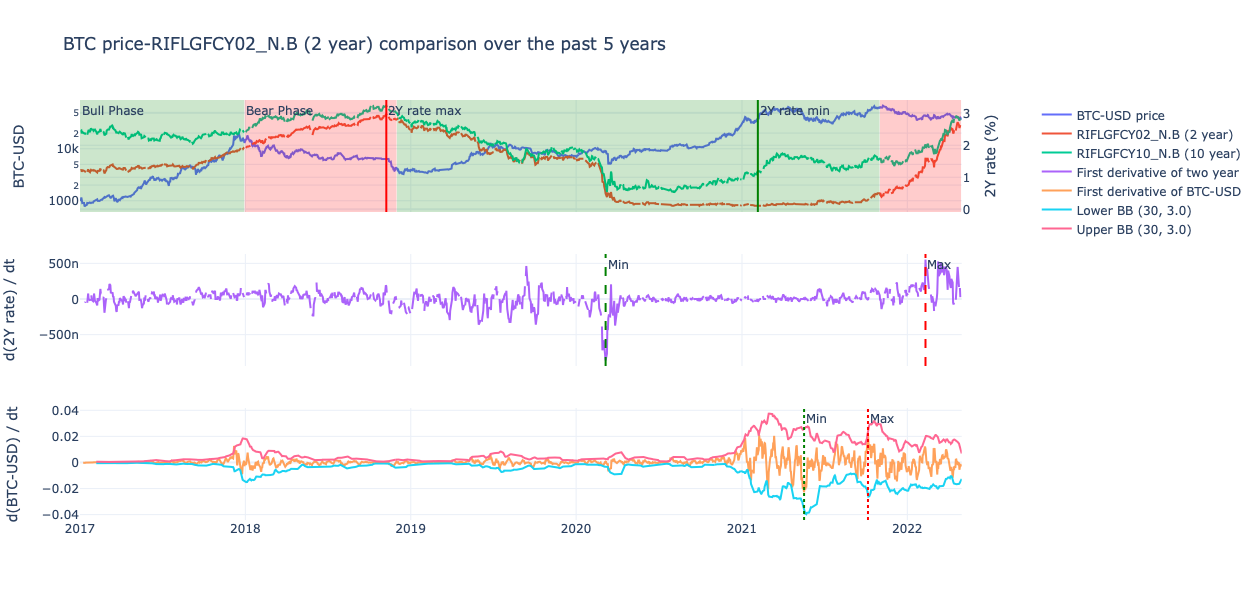

In [43]:
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True, 
    specs=[[{"secondary_y": True}], [{"secondary_y": False}], [{"secondary_y": False}]],
)

fig.add_scatter(
    x=btc_data.index,
    y=btc_data["Adj Close"]["BTC-USD"],
    mode="lines",
    name="BTC-USD price",
    secondary_y=False,
    row=1, col=1
)

fig.add_scatter(
    x=df_rates.index,
    y=df_rates["RIFLGFCY02_N.B"],
    mode="lines",
    name="RIFLGFCY02_N.B (2 year)",
    secondary_y=True,
    row=1, col=1
)

fig.add_scatter(
    x=df_rates.index,
    y=df_rates["RIFLGFCY10_N.B"],
    mode="lines",
    name="RIFLGFCY10_N.B (10 year)",
    secondary_y=True,
    row=1, col=1
)

fig.add_vrect(
    x0="2017-01-01",
    x1="2017-12-30", 
    annotation_text="Bull Phase", 
    annotation_position="top left",
    fillcolor="green", 
    opacity=0.2, 
    line_width=0
)


fig.add_vrect(
    x0="2017-12-30",
    x1="2018-12-01", 
    annotation_text="Bear Phase", 
    annotation_position="top left",
    fillcolor="red", 
    opacity=0.2, 
    line_width=0
)

fig.add_vrect(
    x0="2018-12-01",
    x1="2021-11-01", 
    fillcolor="green", 
    opacity=0.2, 
    line_width=0
)


fig.add_vrect(
    x0="2021-11-01",
    x1="2022-04-30", 
    fillcolor="red", 
    opacity=0.2, 
    line_width=0
)

fig.add_vline(
    df_rates["RIFLGFCY02_N.B"].idxmax().timestamp() * 1000,
    annotation_text="2Y rate max",
    line=dict(color="red"),
    row=1, col=1
)


fig.add_vline(
    df_rates["RIFLGFCY02_N.B"].idxmin().timestamp() * 1000,
    annotation_text="2Y rate min",
    line=dict(color="green"),
    row=1, col=1
)



fig.update_yaxes(
    type="log",
    secondary_y=False,
    row=1, col=1
)


first_deriv_rates = df_rates["RIFLGFCY02_N.B"].diff(periods=7) / df_rates.index.to_series().diff(periods=7).dt.total_seconds()
fig.add_scatter(
    x=df_rates.index,
    y=first_deriv_rates,
    name="First derivative of two year",
    row=2, col=1
)

fig.add_vline(
    first_deriv_rates.idxmin().timestamp() * 1000,
    annotation_text="Min",
    line=dict(color="green", dash="dash"),
    row=2, col=1
)

fig.add_vline(
    first_deriv_rates.idxmax().timestamp() * 1000,
    annotation_text="Max",
    line=dict(color="red", dash="dash"),
    row=2, col=1
)

first_deriv_price = btc_data["Adj Close"]["BTC-USD"].diff(periods=7) / btc_data.index.to_series().diff(periods=7).dt.total_seconds()
second_deriv_price = first_deriv_price.diff(periods=7) / first_deriv_price.index.to_series().diff(periods=7).dt.total_seconds()

fig.add_scatter(
    x=btc_data.index,
    y=first_deriv_price,
    name="First derivative of BTC-USD",
    row=3, col=1
)

fig.add_vline(
    first_deriv_price.idxmin().timestamp() * 1000,
    annotation_text="Min",
    line=dict(color="green", dash="dot"),
    row=3, col=1
)

fig.add_vline(
    first_deriv_price.idxmax().timestamp() * 1000,
    annotation_text="Max",
    line=dict(color="red", dash="dot"),
    row=3, col=1
)


length, std = 30, 3.0
df_boll = ta.bbands(first_deriv_price, length=length, std=std)

fig.add_scatter(
    x=df_boll.index,
    y=df_boll[f"BBL_{length}_{std}"],
    name=f"Lower BB ({length}, {std})",
    row=3, col=1
)

fig.add_scatter(
    x=df_boll.index,
    y=df_boll[f"BBU_{length}_{std}"],
    name=f"Upper BB ({length}, {std})",
    row=3, col=1
)

fig.update_yaxes(title_text="BTC-USD", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="2Y rate (%)", row=1, col=1, secondary_y=True)


fig.update_yaxes(title_text="d(2Y rate) / dt", row=2, col=1)
fig.update_yaxes(title_text="d(BTC-USD) / dt", row=3, col=1)

fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    title_text="BTC price-RIFLGFCY02_N.B (2 year) comparison over the past 5 years"
)

fig.write_image(os.path.join("..", "images", "crypto_interest_rate_comparison.png"))
fig.show()

# Assets: Total Assets: Total Assets (Less Eliminations from Consolidation) (WALCL)

In [44]:
asset_data = os.path.join("..", "data", "WALCL.csv") 

df_assets = pd.read_csv(asset_data)
df_assets['DATE']= pd.to_datetime(df_assets['DATE'])
df_assets.set_index("DATE", inplace=True)

# Overnight Reverse Repurchase Agreements: Treasury Securities Sold by the Federal Reserve in the Temporary Open Market Operations (RRPONTSYD)

In [51]:
rev_repo_data = os.path.join("..", "data", "RRPONTSYD.csv")

df_repo = pd.read_csv(rev_repo_data)
df_repo['DATE']= pd.to_datetime(df_repo['DATE'])
df_repo.set_index("DATE", inplace=True)

df_repo = df_repo.loc[df_repo["RRPONTSYD"] != "."]
df_repo = df_repo.astype("float32")

In [52]:
start_date = datetime.strptime("2010-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2022-05-06", "%Y-%m-%d")
btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start_date, end=end_date)

In [53]:
df_assets = df_assets.loc[btc_data.index[0]:]
df_repo = df_repo.loc[btc_data.index[0]:]

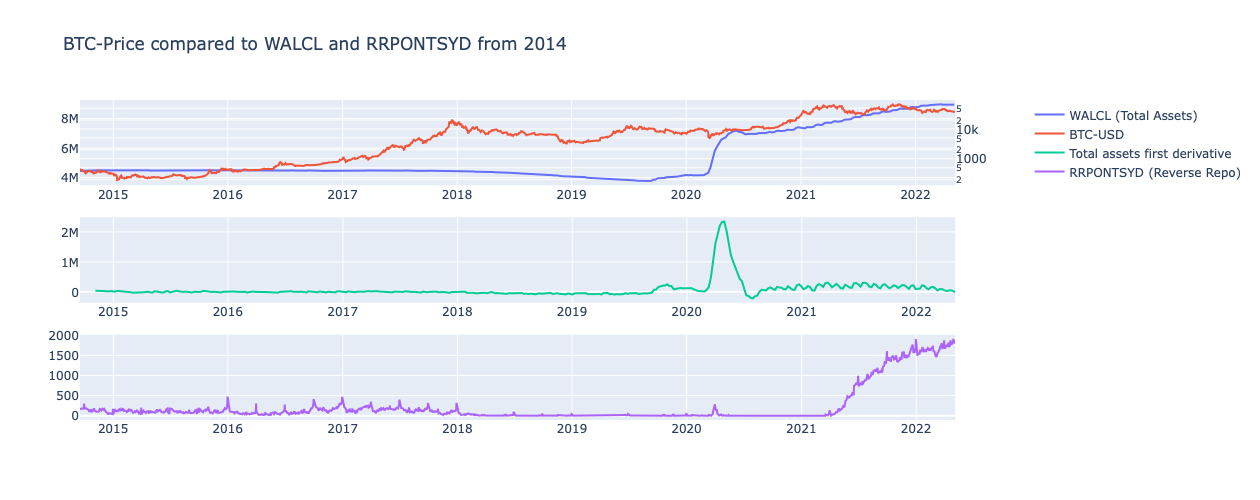

In [56]:
fig = make_subplots(rows=3, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": False}], [{"secondary_y": False}]])

fig.add_scatter(
    x=df_assets.index,
    y=df_assets.WALCL,
    name="WALCL (Total Assets)",
    secondary_y=False,
    row=1, col=1
)


fig.add_scatter(
    x=btc_data.index,
    y=btc_data["Adj Close"]["BTC-USD"],
    name="BTC-USD",
    secondary_y=True,
    row=1, col=1
)

first_der_assets = df_assets.WALCL.diff(periods=7)

fig.add_scatter(
    x=df_assets.index,
    y=first_der_assets,
    name="Total assets first derivative",
    row=2, col=1
)

fig.add_scatter(
    x=df_repo.index,
    y=df_repo["RRPONTSYD"],
    mode="lines",
    name="RRPONTSYD (Reverse Repo)",
    row=3, col=1
)


fig.update_yaxes(type="log", secondary_y=True, row=1, col=1)


fig.update_layout(
    height=500, width=1200, 
    title_text="BTC-Price compared to WALCL and RRPONTSYD from 2014",
)

fig.write_image(os.path.join("..", "images", "crypto_asset_holdings_repo_comparison.png"))
fig.show()